# Predicting the occurrence of fires based on weather observations


Group 17

Lua Presidio, Daniel Hou, Michelle Yan



## Introdution

Forest fires are a recurring natural disaster in numerous places in the world. With increasing risks every year due to climate change, predicting the occurrence of fires is essential to mitigate its environmental, economic, and social risks. [1]

Today, there are many tools used to assess fire risk such as satellite imaging monitoring or ground sensors. Yet, not all locations where forest fires occur have the technology or capacity to utilize those tools. Thus, it is useful to turn to a method of risk prediction that does not rely on sophisticated data collection but still yields relatively accurate results.

One of such systems is the Fire Weather Index (FWI). This system utilizes basic weather observations (temperature, relative humidity, wind speed, and rain) in combination with a standard fuel type (usually defined as a species of pine) to indicate the “dryness of the forest fuel and give a relative measure of the burning conditions that can be expected” [2]. FWI is a good indicator of fire danger, but it does not actually predict the occurrence or not of a fire. 

Thus, we are interested in looking at the basic weather observations to predict the occurrence of a fire and ultimately answer:

> **Can we use a combination of temperature, rain, relative humidity and wind speed to accurately predict if a fire will occur or not?**

For this project we will be using a limited dataset with 244 instances of two different regions in Algeria as a case study. Algeria has a long history of issues with forest fires, being “the fourth most affected country among the countries covered by the European Forest Fire Information System (EFFIS)” [3] specifically in the summer months. Although it is one of the most affected countries in the region, all countries across the Mediterraneean Basin have similar fire occurrence, frequency, size, seasonality, and intensity. [4] Thus, looking at Algeria as a case study might reveal patterns for the region as a whole.

For the purposes of this study we will be combining the observations of the two regions as we are not interested in their particular differences. The data was collected originally between June 2012 and September 2012 for the purposes of testing a decision tree algorithm. The full dataset includes 11 attributes and 1 output attribute, however we will be limiting our data to 6 attributes. The dataset we will be using contains the following attributes: 

* Temperature: Temperature in Celsius degrees for a particular day (ranged from 22 to 42)
* RH: The concentration of water vapor present in the air expressed as a percentage (ranges from 21 to 91)
* Ws: Wind speed in km/h (ranges from 6 to 29)
* Rain: Total rain in mm (ranges from 0 to 16.8)
* Fire Weather Index: The FWI value (ranges from 0 to 31.1)
* Class: Classification for a given day indicating if there was a fire (fire) or if there was not a fire (no fire)

All the climate observation data was collected at noon on all given days in accordance with FWI policy.



## Methods and Results

In [109]:
# run first

library(tidyverse)
library(tidymodels)
library("GGally")
library(stringr)
library(repr)

In [118]:
set.seed(535)

fire_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)

fire_data2  <- fire_data %>%
    mutate(seq = 1:nrow(fire_data)) %>%
    mutate(Region = case_when(seq < 123 ~ "Bejaia",
                              TRUE ~ "Sidi-Bel Abbes"))

fire_data_fix <- fire_data2 %>%
    filter(seq == 168) %>%
    separate(col = "DC", into = c("DC", "new"), sep = " ") %>%
    mutate(Classes = FWI)%>%
    mutate(FWI = BUI) %>%
    mutate(BUI = ISI) %>%
    mutate(ISI = new) %>%
    select(-new)
    
fire_data2 <- fire_data2[-c(123,124, 168), ] 

fire_data_comp <- rbind(fire_data2, fire_data_fix)

numerics <- c("day", "month", "year", "Temperature", "RH", "Ws", "Rain", "FFMC", "DMC", "DC", "ISI", "BUI", "FWI")

fire_data_comp <- select(fire_data_comp, -seq) %>%
    type.convert(as.is = TRUE) %>%
    mutate(Classes = as.factor(Classes))

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


To load the data from the web, we too the url, skipping the first line of metadata. Since the data is split into regions, each with their own table, we need to remove the lines that separates the data into two regions (column headers and region name). Finally we fix one line of data that was improperly inputted. After fixing the line, we add the fixed line back into our data and fixed the vector type into the correct types.

In [119]:
set.seed(10)
fire_data_split <- initial_split(fire_data_comp, prop = 0.75, strata = Classes)
fire_data_training <- training(fire_data_split)
fire_data_testing <- testing(fire_data_split)

We then split our data into training and testing sets, and because the total number of observations are quite low, we have a high proportion of our training to testing set.

### Exploratory table

In [120]:
#create data for temp avg, wind speed avg, rain avg, FWI avg and number of observations
fire_data_training %>%
    select(-(day:year), -(FFMC:BUI)) %>%
    group_by(Classes) %>%
    summarize(Temperature_avg = mean(Temperature),
              Ws_avg = mean(Ws),
              Rain_avg = mean(Rain),
              RH_avg = mean(RH),
              n = n())

`summarise()` ungrouping output (override with `.groups` argument)



Classes,Temperature_avg,Ws_avg,Rain_avg,RH_avg,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
fire,33.55769,15.21154,0.1192308,57.000,104
not fire,30.01250,15.98750,1.7312500,68.825,80


This table shows the means of our predictor variables: Average temperature (Celcius), wind speed (km/h), Rain (mm), and Relative Humidity (%) and shows the total number of instances for each Class.

### Exploratory plots

In [121]:
# options(repr.plot.height = 20, repr.plot.width = 25)

# fire_data_training %>%
#     select(-day, -month, -year, -seq, -(FFMC:BUI)) %>%
#     ggpairs(axisLabels = "show") +
#     theme(text = element_text(size = 20))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



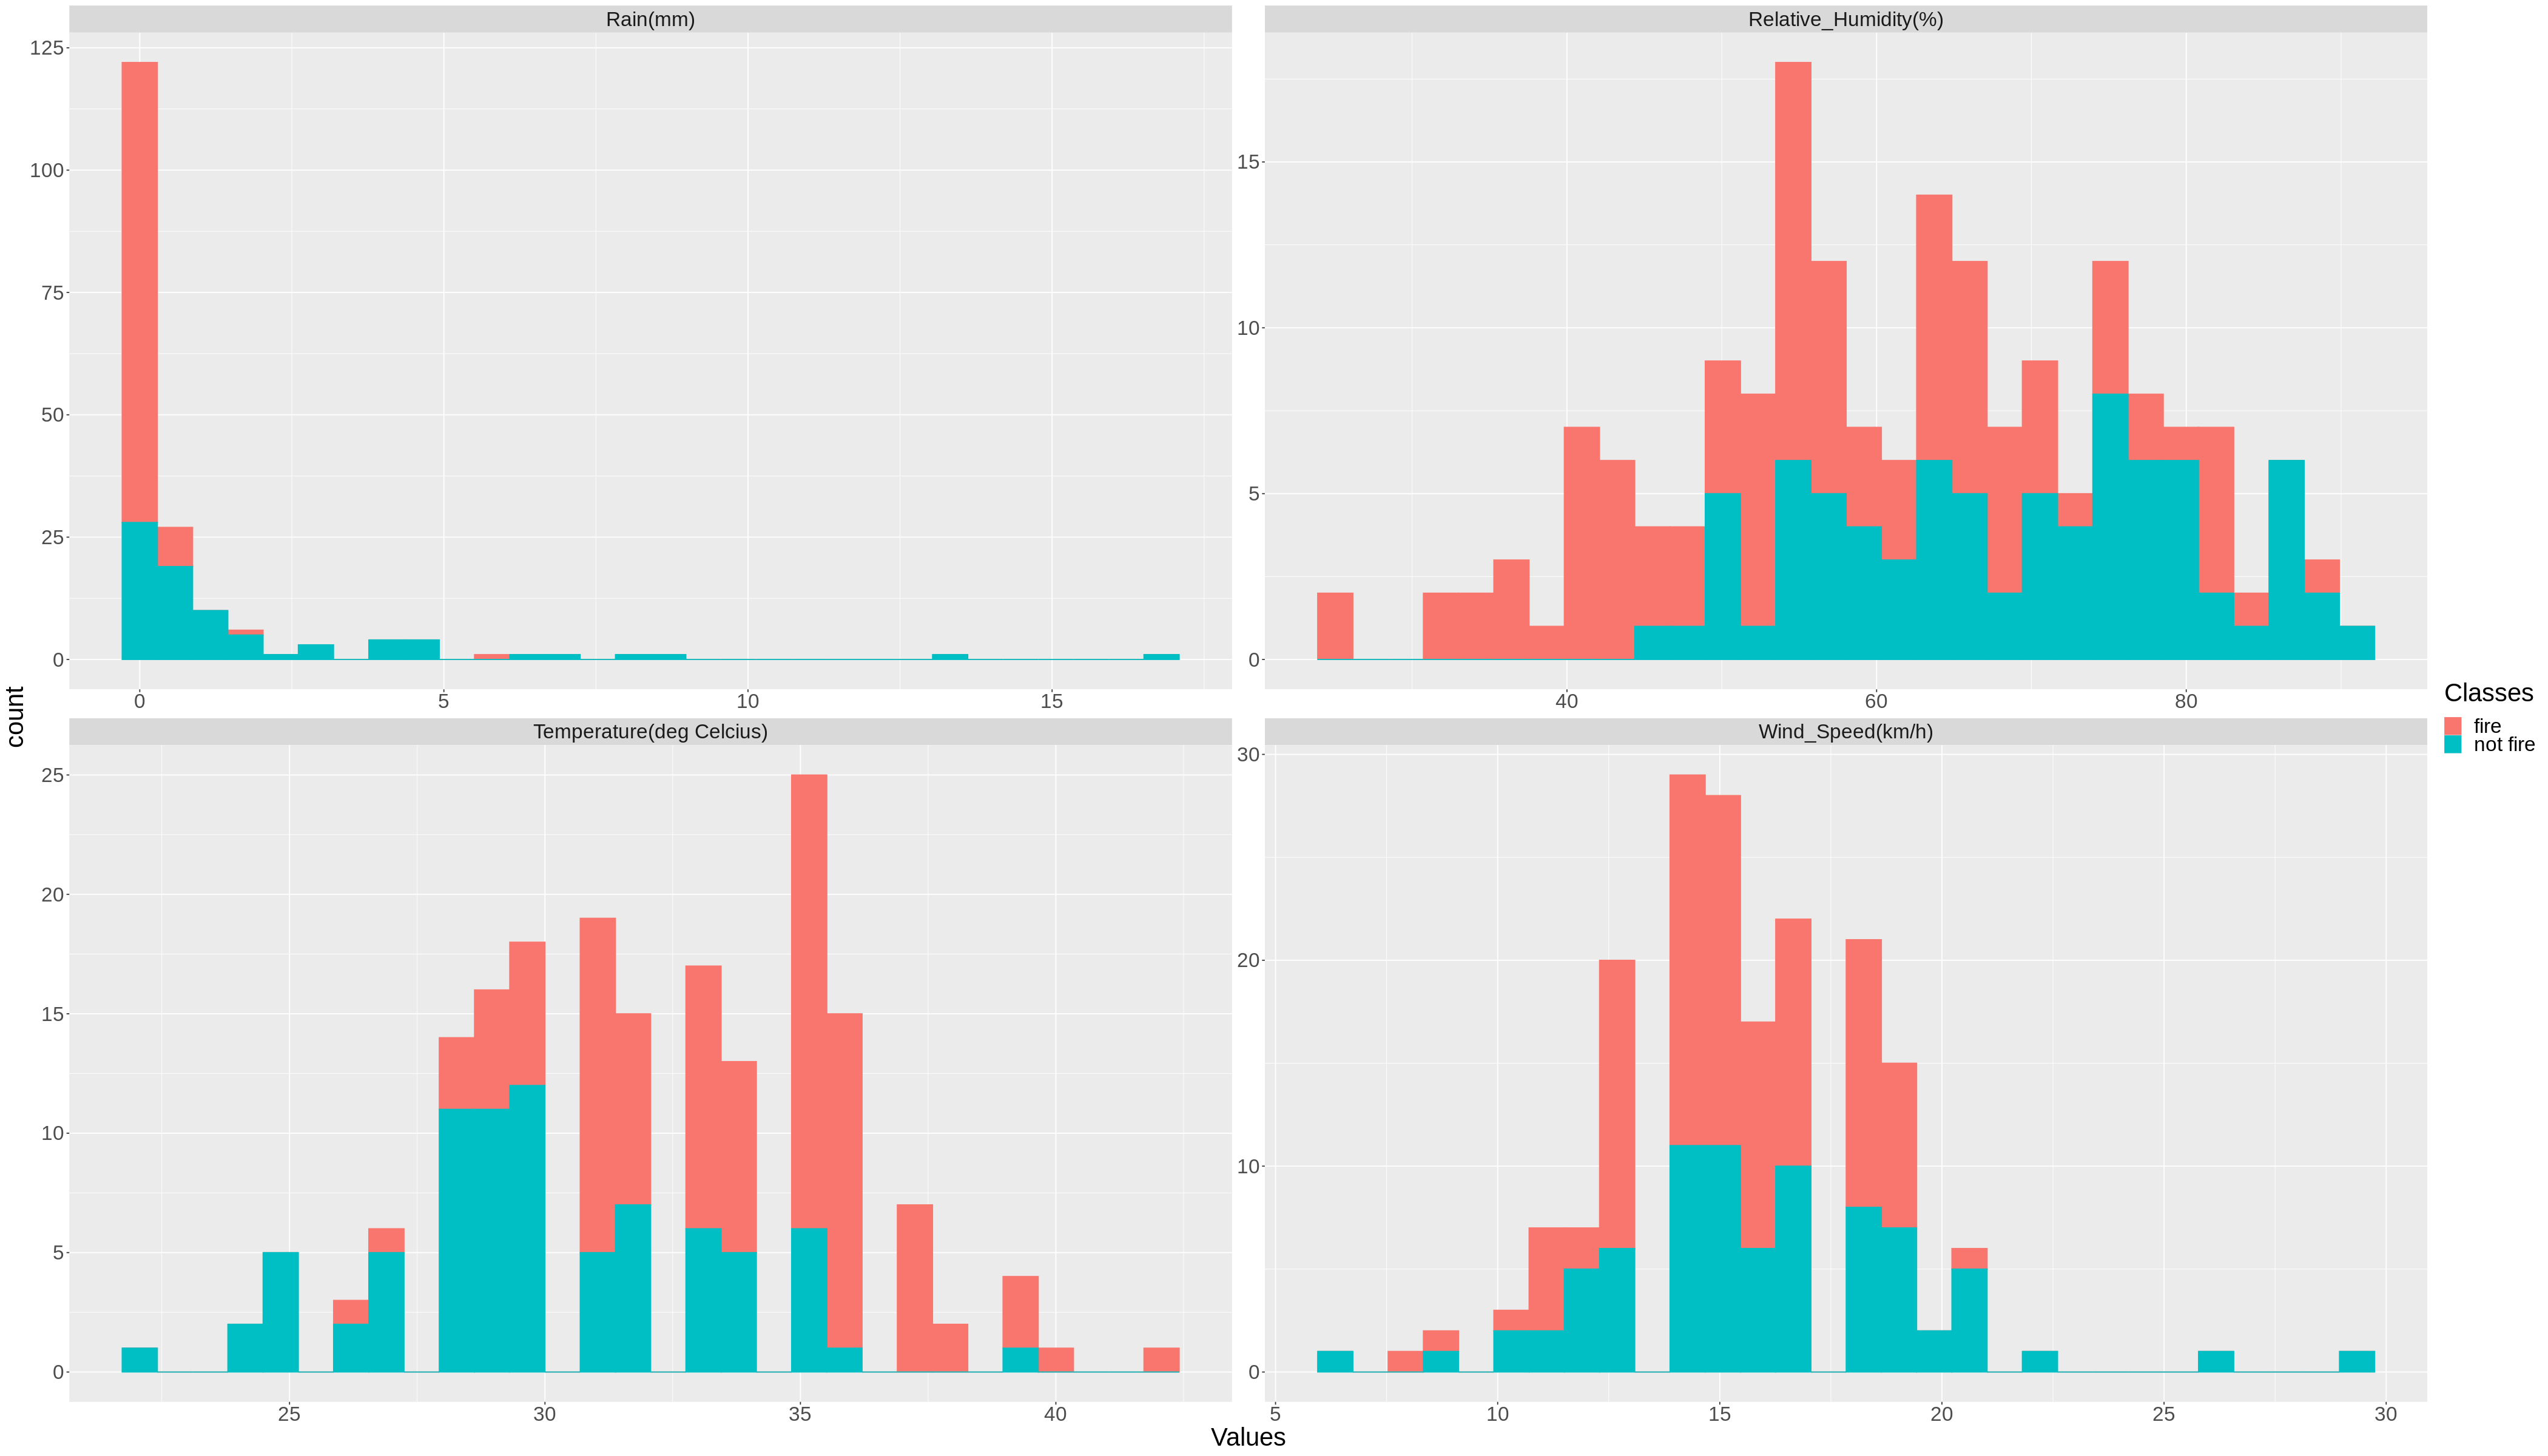

In [122]:
options(repr.plot.height = 20, repr.plot.width = 35)

# Making a plot that shows the distributions of our predictor variables. 

fire_data_training %>%
    mutate("Rain(mm)" = Rain) %>%
    mutate("Relative_Humidity(%)" = RH) %>%
    mutate("Temperature(deg Celcius)" = Temperature) %>%
    mutate("Wind_Speed(km/h)" = Ws) %>%
    select("Rain(mm)":"Wind_Speed(km/h)", Classes) %>%
    pivot_longer(- Classes,
                names_to = "variable",
                values_to = "values") %>%
    ggplot(aes(x = values, color = Classes, fill = Classes)) +
    geom_histogram() +
    facet_wrap(~ variable, scales = "free", ncol = 2) +
    xlab("Values") +
    theme(text = element_text(size = 25))



##### Rain distribution

Both classes are centered at ~0. The class "not fire" is more spread out than the class "fire", so "not fire" has a greater range. 

#####  Relative humidity distribution (RH)

There are more instances of "fire" when RH < 40. We see roughly the same number of instances of both classes between ~44 to 70, although "fire" is centered at ~55 while "not fire' is centered at ~70. At RH > 70, "not fire" instances are greater than "fire" instances. "fire" has a greater range than "not fire".

##### Temperature distribution

The range for both classes are about the same. "Not fire" is shifted towards lower temperatures, while "fire" is shifted towards higher temperatures. "fire" is centered at ~35°C and more instances occur at temperatures > 30°C. "not fire" is centered at ~28°C and more instances occur at temperatures < 30°C.

##### Wind speed distribution (Ws)

There is a relatively even number of instances for "fire" and "not fire" in the 10km/h - 20km/h range and therefore are both centered at ~15-16 km/h. "Not fire" has a few instances of high and low wind speeds, so it has a greater range than "fire". 

### Data Analysis (finding K)

In [125]:
set.seed(535)
options(repr.plot.height = 10, repr.plot.width = 15)

fire_recipe <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = fire_data_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
fire_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

To build our recipe, we got rid of the day, month, year, FFMC, DMC, DC, ISI, BUI, and FWI columns as they aren't relevant in our analysis. We used the RH, Rain, Temperature and WS columns as those are the 4 variables we're comparing to predict whether or not a fire occurs. We then scale our variables since the magnitude of RH would be higher than that of Ws or Temperature.

In [126]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fire_vfold <- vfold_cv(fire_data_training, v = 5, strata = Classes) 

fire_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

fire_results <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = fire_vfold, grid = fire_vals) %>%
    collect_metrics()

fire_accuracy <- fire_results %>%
    filter(.metric == "accuracy")

We used multivariate K-NN classification to make our predictions and compute the distance between the new observation and the observations in the training set. We do 5-fold cross validation to pick our best K, up to 15 neighbours, so we dont end up using too much computational power. When building our model, we use the tune() function instead of inputting a neighbour because we want to find the best K to use to build our classifier. We such, we use tune_grid() to do cross validation on each value of K from 1 to 15. Finally, to determine which K provides the best accuracy, we filter the results for the accuracy in order to plot accuracy vs K.

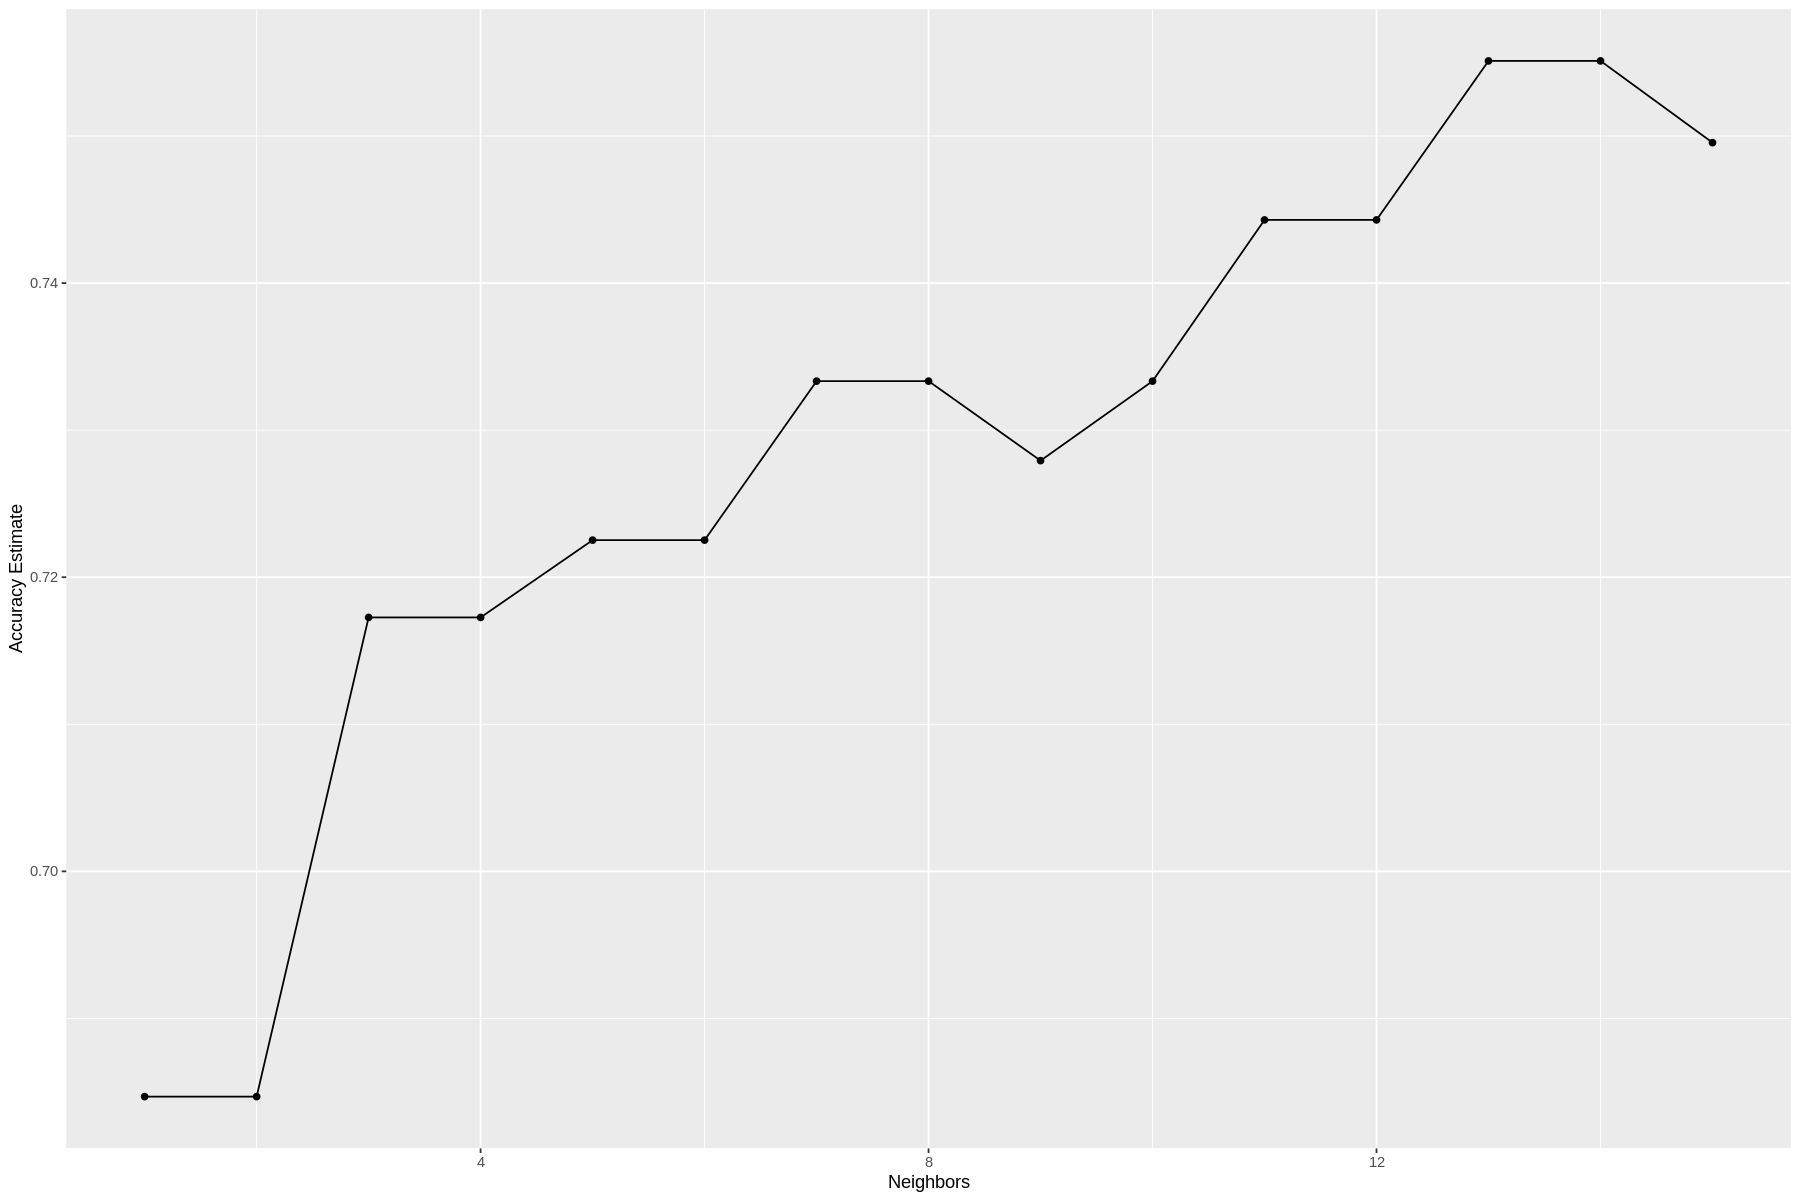

In [127]:
accuracy_vs_k <- ggplot(fire_accuracy, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k

From this graph, it appears that we have the highest accuracy when we have K = 13 or K = 14. We choose K=14 because subtracting one neighbour doesnt reduce the accuracy and adding one neighbour only reduces it by a small amount. Furthermore, k = 14 isnt prohibitively expensive in terms of computational cost.

### Data Analysis (building the classifier and predictions)

In [130]:
set.seed(535)
fire_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fire_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(fire_spec2) %>%
    fit(data = fire_data_training)

fire_data_predictions <- predict(fire_fit, fire_data_testing) %>%
    bind_cols(fire_data_testing) 

fire_data_predictions %>%
    metrics(truth = Classes, estimate = .pred_class)

confusion <- fire_data_predictions %>%
             conf_mat(truth = Classes, estimate = .pred_class)

confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7333333
kap,binary,0.4202899


          Truth
Prediction fire not fire
  fire       33       15
  not fire    1       11

Finally, we do K-NN classification, building a new model with 14 neighbours and passing in our training data using fit. Finally, we test our predictions by passing in our testing set and the fit object we created. To find out the accuracy of our classifier, we used the metrics function with Classes being truth and the .pred_class as the estimate. For more information on its accuracy, we also looked at the confusion 

## Expected outcomes and significance:




We expect to create, based on our chosen variables, an accurate fire prediction model able to predict fires around the Mediterranean. The impact is the lack of need for sophisticated fire analysis, relying only on basic weather observations to predict a fire.

The future question this could lead to is regarding the strength in relationship between one of the weather observations and different Fire Code values. For example, is temperature more significant than relative humidity in the risk of fire? Another possible question would be if from these observations alone (without utilizing additional codes) can we predict a FWI value?


## References

1. Arif M, Alghamdi KK, Sahel SA, et al. , "Role of Machine Learning Algorithms in Forest Fire Management: A Literature Review". J Robotics Autom 5(1):212-226. 2021. https://scholars.direct/Articles/robotics/jra-5-024.php?jid=robotics.
2. “Understanding Fire Weather.” Alberta Wildfire | AAF - Agriculture and Forestry. https://wildfire.alberta.ca/wildfire-status/fire-weather/understanding-fire-weather.aspx. 
4. Faroudja ABID et al. , "Predicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithm", International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019), 08 - 11 July, 2019, Marrakech, Morocco.
5. Curt, Thomas, Aissa Aini, and Sylvain Dupire. “Fire Activity in Mediterranean Forests (the Algerian Case).” Fire 3, no. 4 (2020): 58. https://doi.org/10.3390/fire3040058. 

